In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
from sqlalchemy import inspect
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
    
print()

columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


<Figure size 432x288 with 0 Axes>

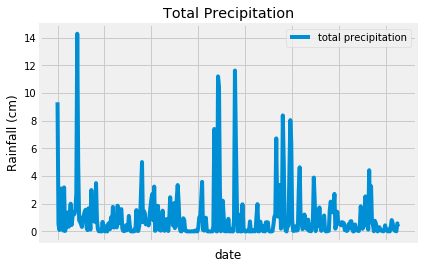

<Figure size 432x288 with 0 Axes>

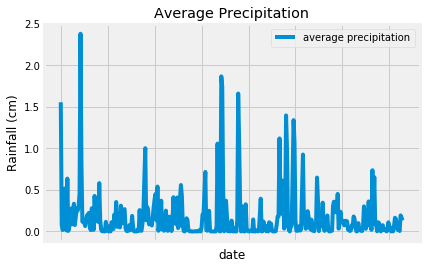

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
query = (Measurement.date, )

last_day = session.query(*query).\
    order_by(Measurement.date.desc()).first()[0]
last_day_dt = dt.datetime.strptime(last_day, '%Y-%m-%d').date()
one_year_ago = last_day_dt - dt.timedelta(days=365)
one_year_ago_str = str(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
query = (Measurement.date, func.sum(Measurement.prcp), func.avg(Measurement.prcp))

result = session.query(*query).\
    filter(Measurement.date > one_year_ago_str).\
    order_by(Measurement.date).\
    group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(result, columns=['date', 'total precipitation', 'average precipitation'])

# Sort the dataframe by date
df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure();
df.plot(x='date', y='total precipitation');
plt.title('Total Precipitation');
plt.ylabel('Rainfall (cm)');

path = os.path.join('images', 'total_precipitation.png')
plt.savefig(path)

plt.figure();
df.plot(x='date', y='average precipitation');
plt.title('Average Precipitation');
plt.ylabel('Rainfall (cm)');

path = os.path.join('images', 'average_precipitation.png')
plt.savefig(path)

plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,total precipitation,average precipitation
count,365.000000,365.000000
mean,0.974164,0.169987
std,1.776466,0.295722
min,0.000000,0.000000
25%,0.050000,0.008571
50%,0.400000,0.070000
75%,1.080000,0.191667
max,14.280000,2.380000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
query = (func.count(Station.id), )

num_stations = session.query(*query).all()
num_stations

[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = (Measurement.station, func.count(Measurement.station))

station_records = session.query(*query).\
        order_by(func.count(Measurement.station).desc()).\
        group_by(Measurement.station).all()
station_records

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
top_station = station_records[0][0]

query = (func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))

most_active_temps = session.query(*query).\
    filter(Measurement.station == top_station).all()
most_active_temps

[(54.0, 71.66378066378067, 85.0)]

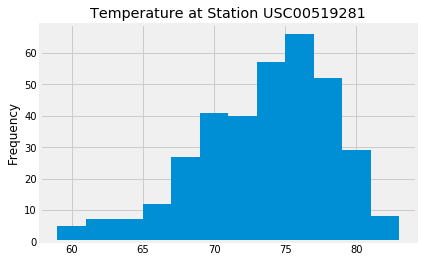

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results
# as a histogram

query = (Measurement.tobs, )

most_active_tobs = session.query(*query).\
    filter(Measurement.date > one_year_ago_str, Measurement.station == top_station).all()

observations = list(zip(*most_active_tobs))
plt.hist(observations, bins=12);
plt.ylabel('Frequency');
plt.title(f'Temperature at Station {top_station}');
path = os.path.join('images', f'temperature_histogram_{top_station}.png')
plt.savefig(path)

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    query = (func.min(Measurement.tobs), func.avg(Measurement.tobs),
             func.max(Measurement.tobs))
    
    return session.query(*query).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-01-01'
trip_end = '2017-01-20'

(tmin, tavg, tmax) = calc_temps(trip_start, trip_end)[0]
print(tmin, tavg, tmax)

60.0 69.49180327868852 81.0


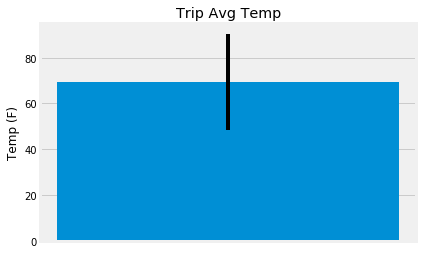

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = tmax - tmin
plt.bar(x=0, height=tavg, yerr=yerr);
frame = plt.gca();
frame.axes.get_xaxis().set_ticks([]);
plt.title('Trip Avg Temp');
plt.ylabel('Temp (F)');
path = os.path.join('images', 'temp_bar_chart.png')
plt.savefig(path)

In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, 
# longitude, and elevation
query = (Measurement.station, Station.name, Station.latitude, Station.longitude, 
         Station.elevation, func.sum(Measurement.prcp).label('Total Precipitation'))

trip_precipitation = session.query(*query).\
        filter(Measurement.date >= trip_start, Measurement.date <= trip_end, 
               Station.station == Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).\
        group_by(Station.station).all()

trip_precipitation

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.71),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.63),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.61),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.35),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.23),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]

## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    query = (func.min(Measurement.tobs), func.avg(Measurement.tobs), 
             func.max(Measurement.tobs))
    return session.query(*query).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = list()
days_list = list()
month = '01'
for days in range(1, 21):
    # day = str(dt.datetime.strptime(str(days), '%d'))
    # print(month, day)
    if days < 10:
        days = f'0{days}'
    month_day = f'{month}-{days}'
    normal = daily_normals(month_day)
    days_list.append(dt.datetime.strptime(f'2017-{month_day}', '%Y-%m-%d'))
    normals.append(normal[0])
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0),
 (56.0, 69.31372549019608, 78.0),
 (54.0, 68.62962962962963, 80.0),
 (61.0, 69.07407407407408, 76.0),
 (57.0, 68.63157894736842, 77.0),
 (60.0, 68.26315789473684, 78.0),
 (61.0, 68.86666666666666, 78.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'], index=days_list)
trip_df

,tmin,tavg,tmax
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0
2017-01-08,57.0,67.160714,75.0
2017-01-09,58.0,67.929825,78.0
2017-01-10,62.0,69.741379,77.0


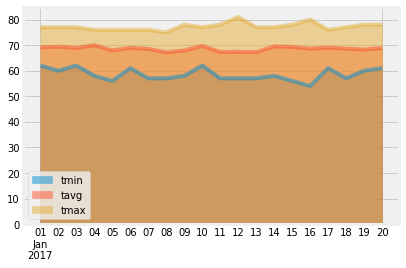

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False);
path = os.path.join('images', 'daily_normals.png')
plt.savefig(path)